# Experiment 2: High Resolution Spectroscopy, Linear Spectrum
## Experimentalpraktikum A, Universität Innsbruck, WS 2025/26
### Zarah Aigner 

In [2]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import configparser
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pandas as pd
from scipy.constants import e, c, h, nano
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from scipy.optimize import curve_fit
from scipy.special import wofz
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, t as tdist

font1 = {'family':'sans-serif','color':'black','size':12}
font2 = {'family':'sans-serif','color':'black','size':20}

plt.rcParams['text.usetex'] = True #LaTeX

## Conversion of the time to frequency -> x Axis

Index(['time', 'CH1', 'CH2', 'CH3'], dtype='object')
          time   CH1     CH2  CH3
0    -0.000406  0.08  0.0076  608
1    -0.000403  0.08  0.0068  608
2    -0.000400  0.16  0.0068  608
3    -0.000397  0.48  0.0076  608
4    -0.000394  2.08  0.0068  608
...        ...   ...     ...  ...
1995  0.005978  0.00  0.0036  784
1996  0.005981  0.00  0.0036  788
1997  0.005984  0.00  0.0036  784
1998  0.005987  0.00  0.0036  784
1999  0.005990  0.00  0.0036  784

[2000 rows x 4 columns]


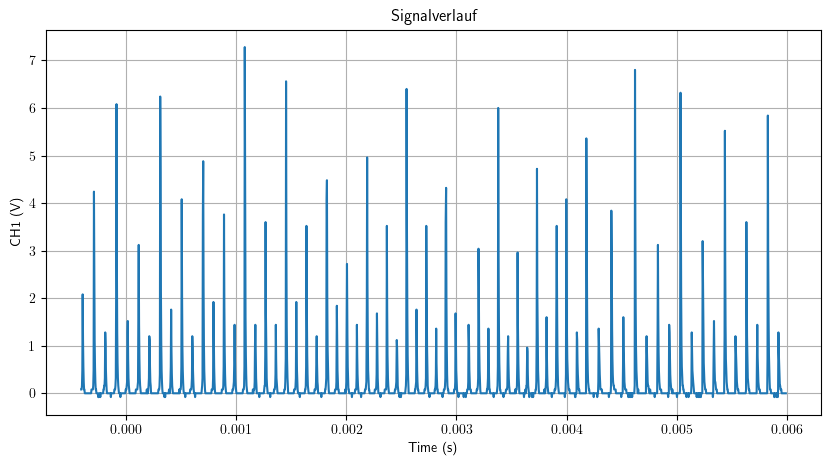

In [3]:
pathname = "/Users/zarahaigner/Documents/Physik_Master_1/FP_2/High_resolution/Data_A2_overall.csv"                  #Data_Nonlinear-final.csv" #Data_A2_overall.csv #insert path name, if code is reused please modify
data = pd.read_csv(pathname, header=None, names=["time", "CH1", "CH2", "CH3"])
print(data.columns)
time = data["time"]
ch1 = data["CH1"]
ch2 = data["CH2"]
ch3 = data["CH3"]

print(data)

plt.figure(figsize=(10,5))
plt.plot(time, ch1)
plt.xlabel("Time (s)")
#plt.xlim(0.0010,0.004)
plt.ylabel("CH1 (V)")
plt.title("Signalverlauf")
plt.grid(True)
plt.show()

0.0004029999999999997


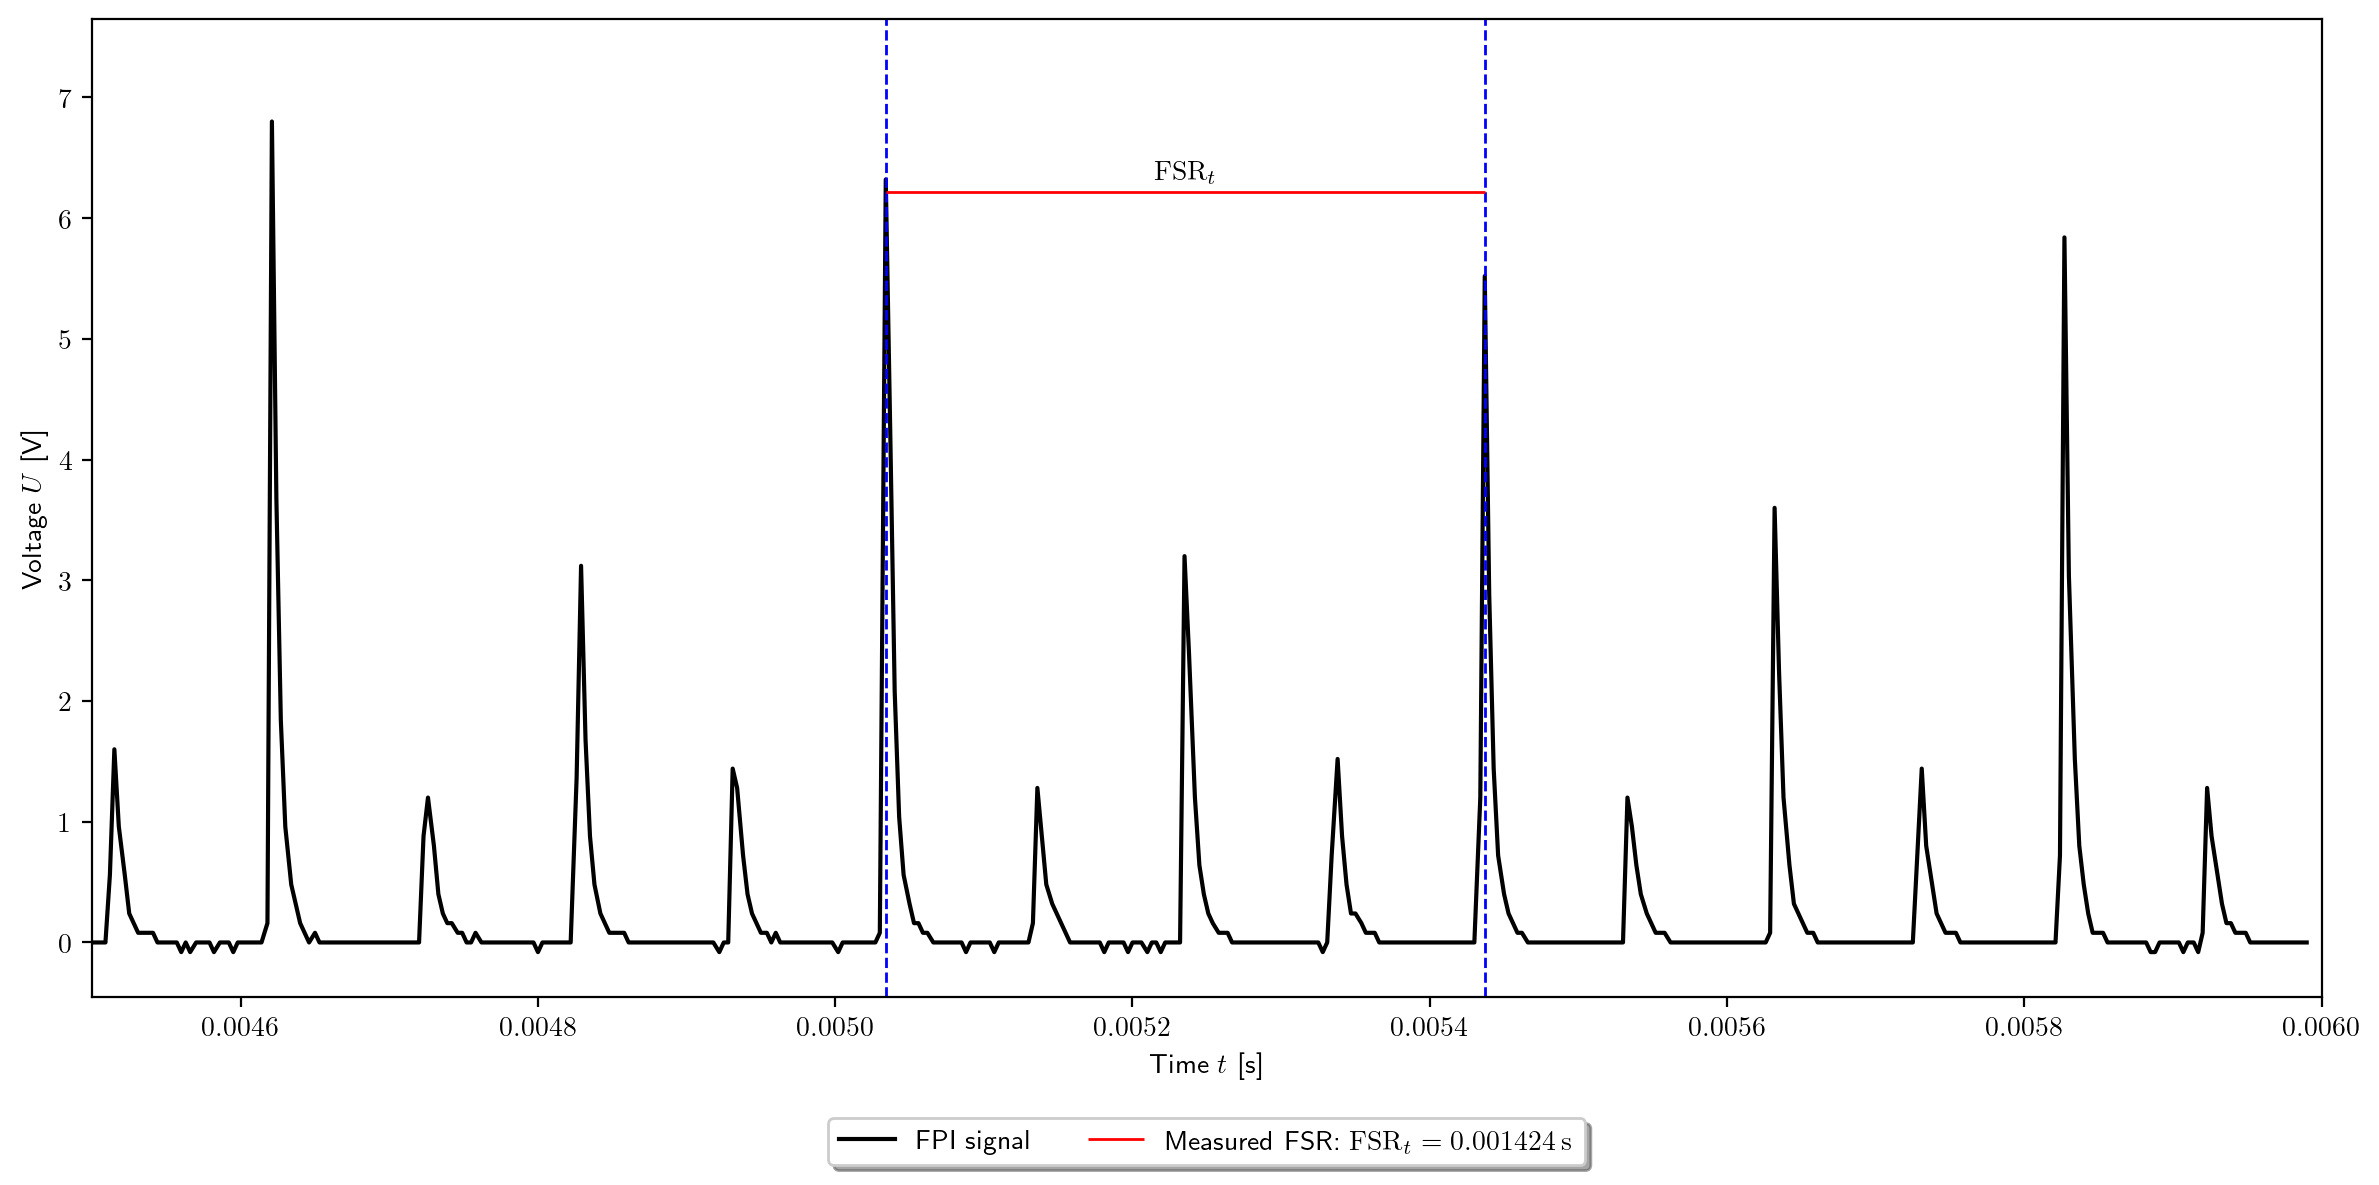

In [4]:
# loading the data -> converting to numpy arrays
t   = np.array(time)
sig = np.array(ch1)

# defining the masks to find the FSR of the data
mask1 = (t > 0.005) & (t < 0.0054) #(t > 0.004) & (t < 0.0045)#(t > 0.0025) & (t < 0.0026)
t1_candidates = t[mask1]
s1_candidates = sig[mask1]

idx1_local = np.argmax(s1_candidates)
t1 = t1_candidates[idx1_local]
A1 = s1_candidates[idx1_local]

mask2 = (t > 0.0054) & (t < 0.0058)#(t > 0.0045) & (t < 0.0050)
t2_candidates = t[mask2]
s2_candidates = sig[mask2]

idx2_local = np.argmax(s2_candidates)
t2 = t2_candidates[idx2_local]
A2 = s2_candidates[idx2_local]

# Computing FSR
FSR_time = t2 - t1#0.0015
FSR_freq = 1.50e9   # 1.50 GHz -> cpmputed with values from the script
print(FSR_time)

alpha = FSR_freq / FSR_time

# plot to ensure the FSR determination works
plt.figure(figsize=(12,6), dpi=200)
plt.plot(t, sig, label=r"FPI signal", color="black")
plt.axvline(t1, color="blue", linestyle="--", linewidth=1)
plt.axvline(t2, color="blue", linestyle="--", linewidth=1)
y_line = max(A1, A2) - 0.1    # etwas oberhalb der Peak-Höhen

plt.hlines(
    y=y_line, 
    xmin=t1, xmax=t2, 
    color="red", 
    linestyle="-", 
    linewidth=1,
    label=r"Measured FSR: $\mathrm{FSR}_t=0.001424\:\mathrm{s}$"
)

plt.text((t1+t2)/2, y_line + 0.1, r"$\mathrm{FSR}_t$", ha="center")
plt.xlim(0.0045, 0.006)
plt.xlabel(r"Time $t$ [s]")
plt.ylabel(r"Voltage $U$ [V]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig("A1_determination_FSR.pdf")
plt.show()


In [5]:
print("FSR (in Zeit) =", FSR_time, "s pro Resonanz")

# frequency FSR
FSR_freq = 1.50e9  # 1.50 GHz

# Sweepvelocity
alpha = FSR_freq / FSR_time
print("\nSweep-Geschwindigkeit α =", alpha, "Hz/s")



FSR (in Zeit) = 0.0004029999999999997 s pro Resonanz

Sweep-Geschwindigkeit α = 3722084367245.66 Hz/s


t0 = -0.0004064


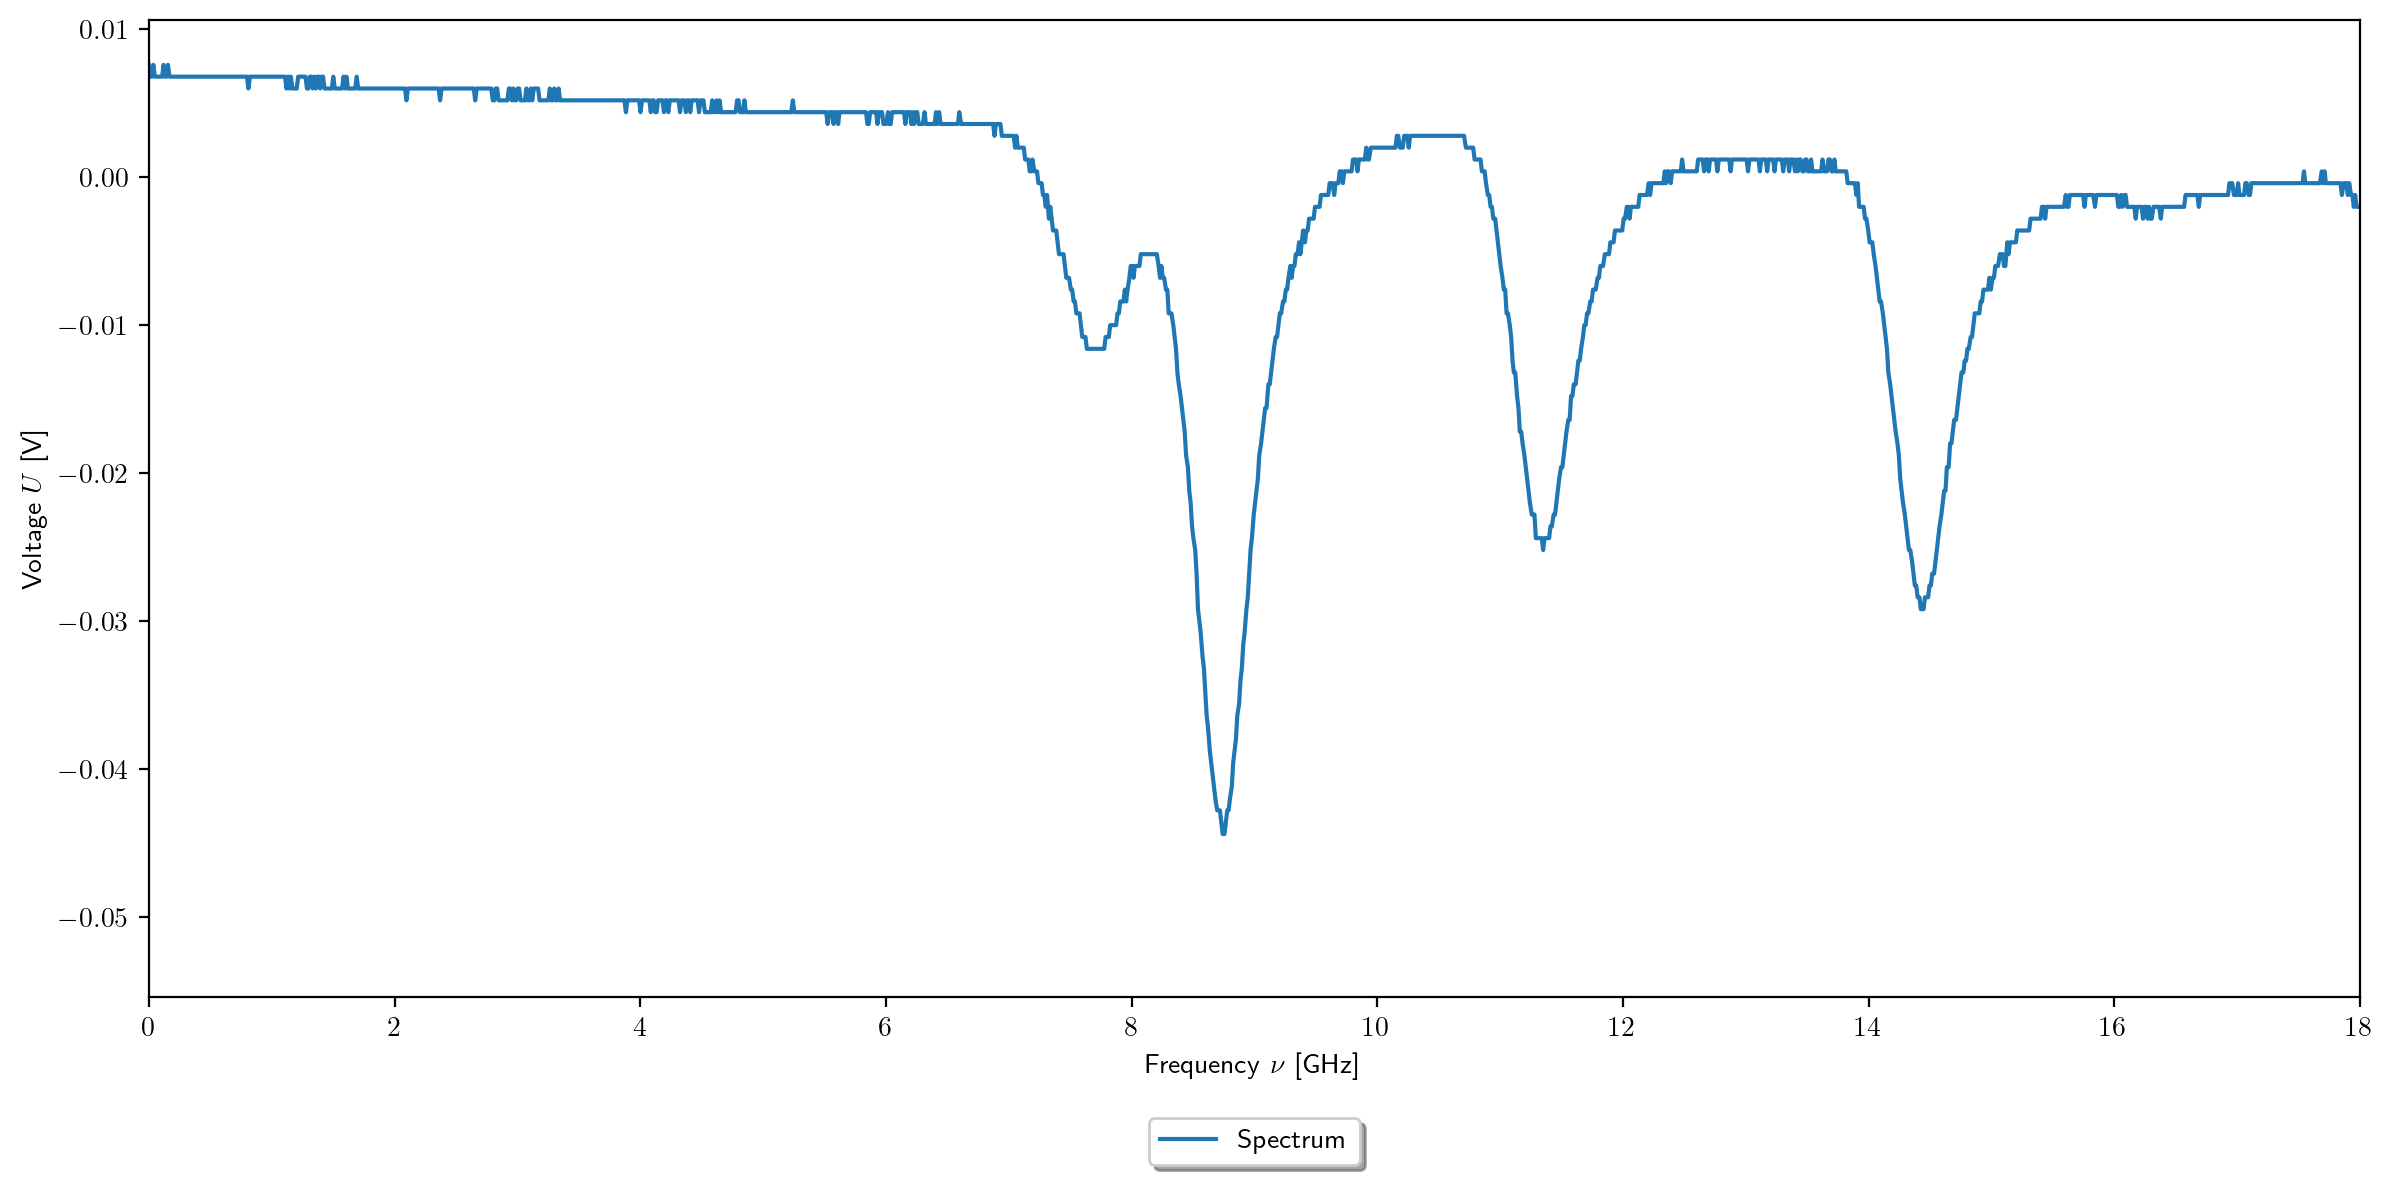

Background-Fit: CH2_bg = -0.0000 * CH3 + 0.0207


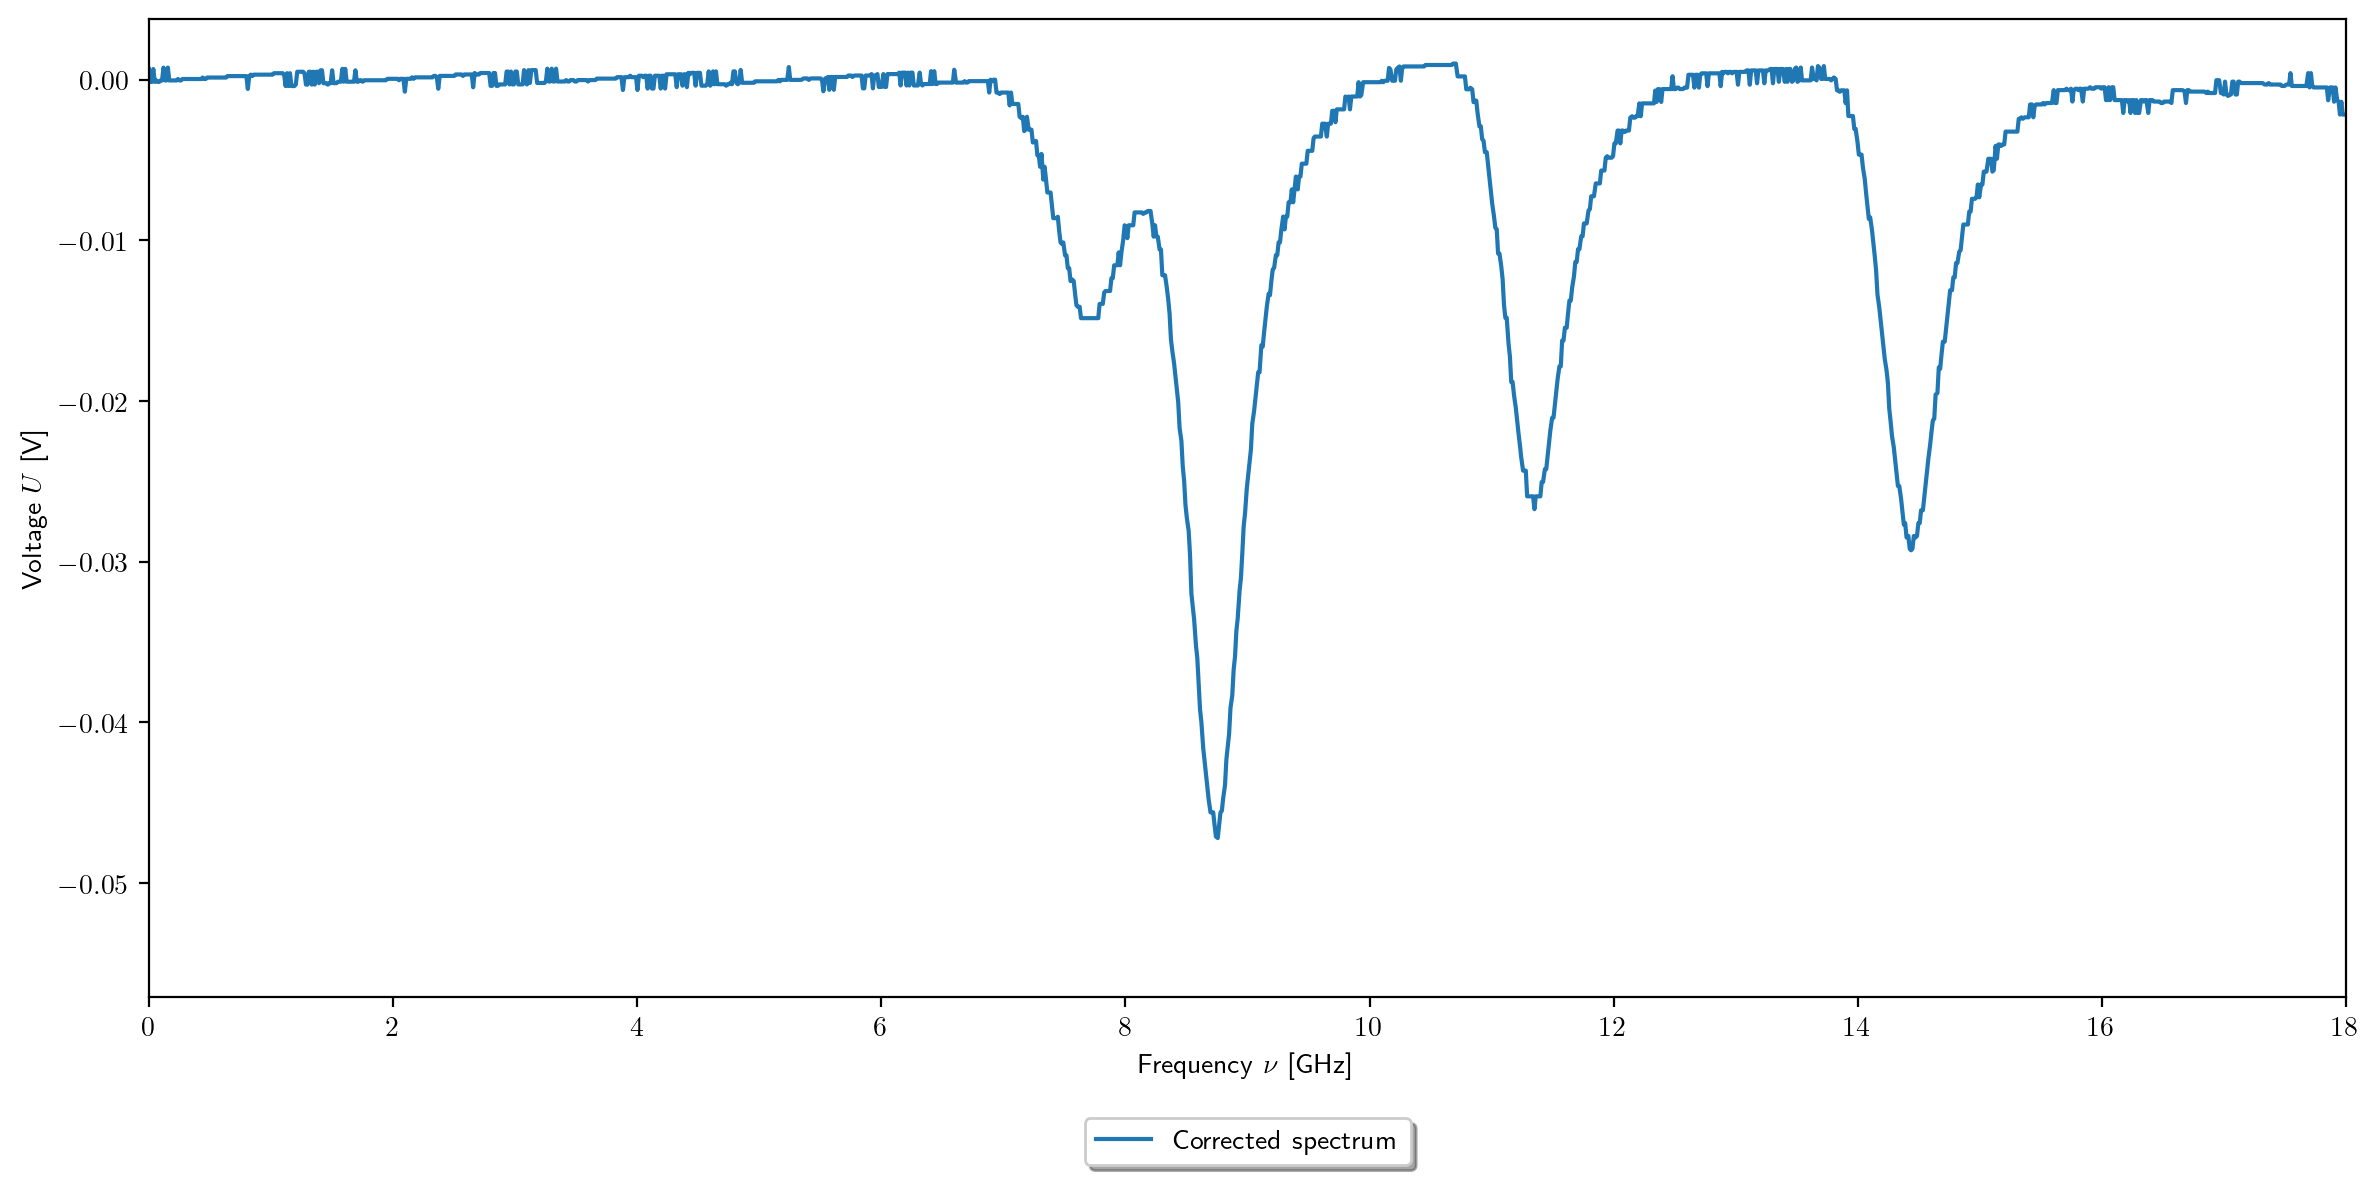

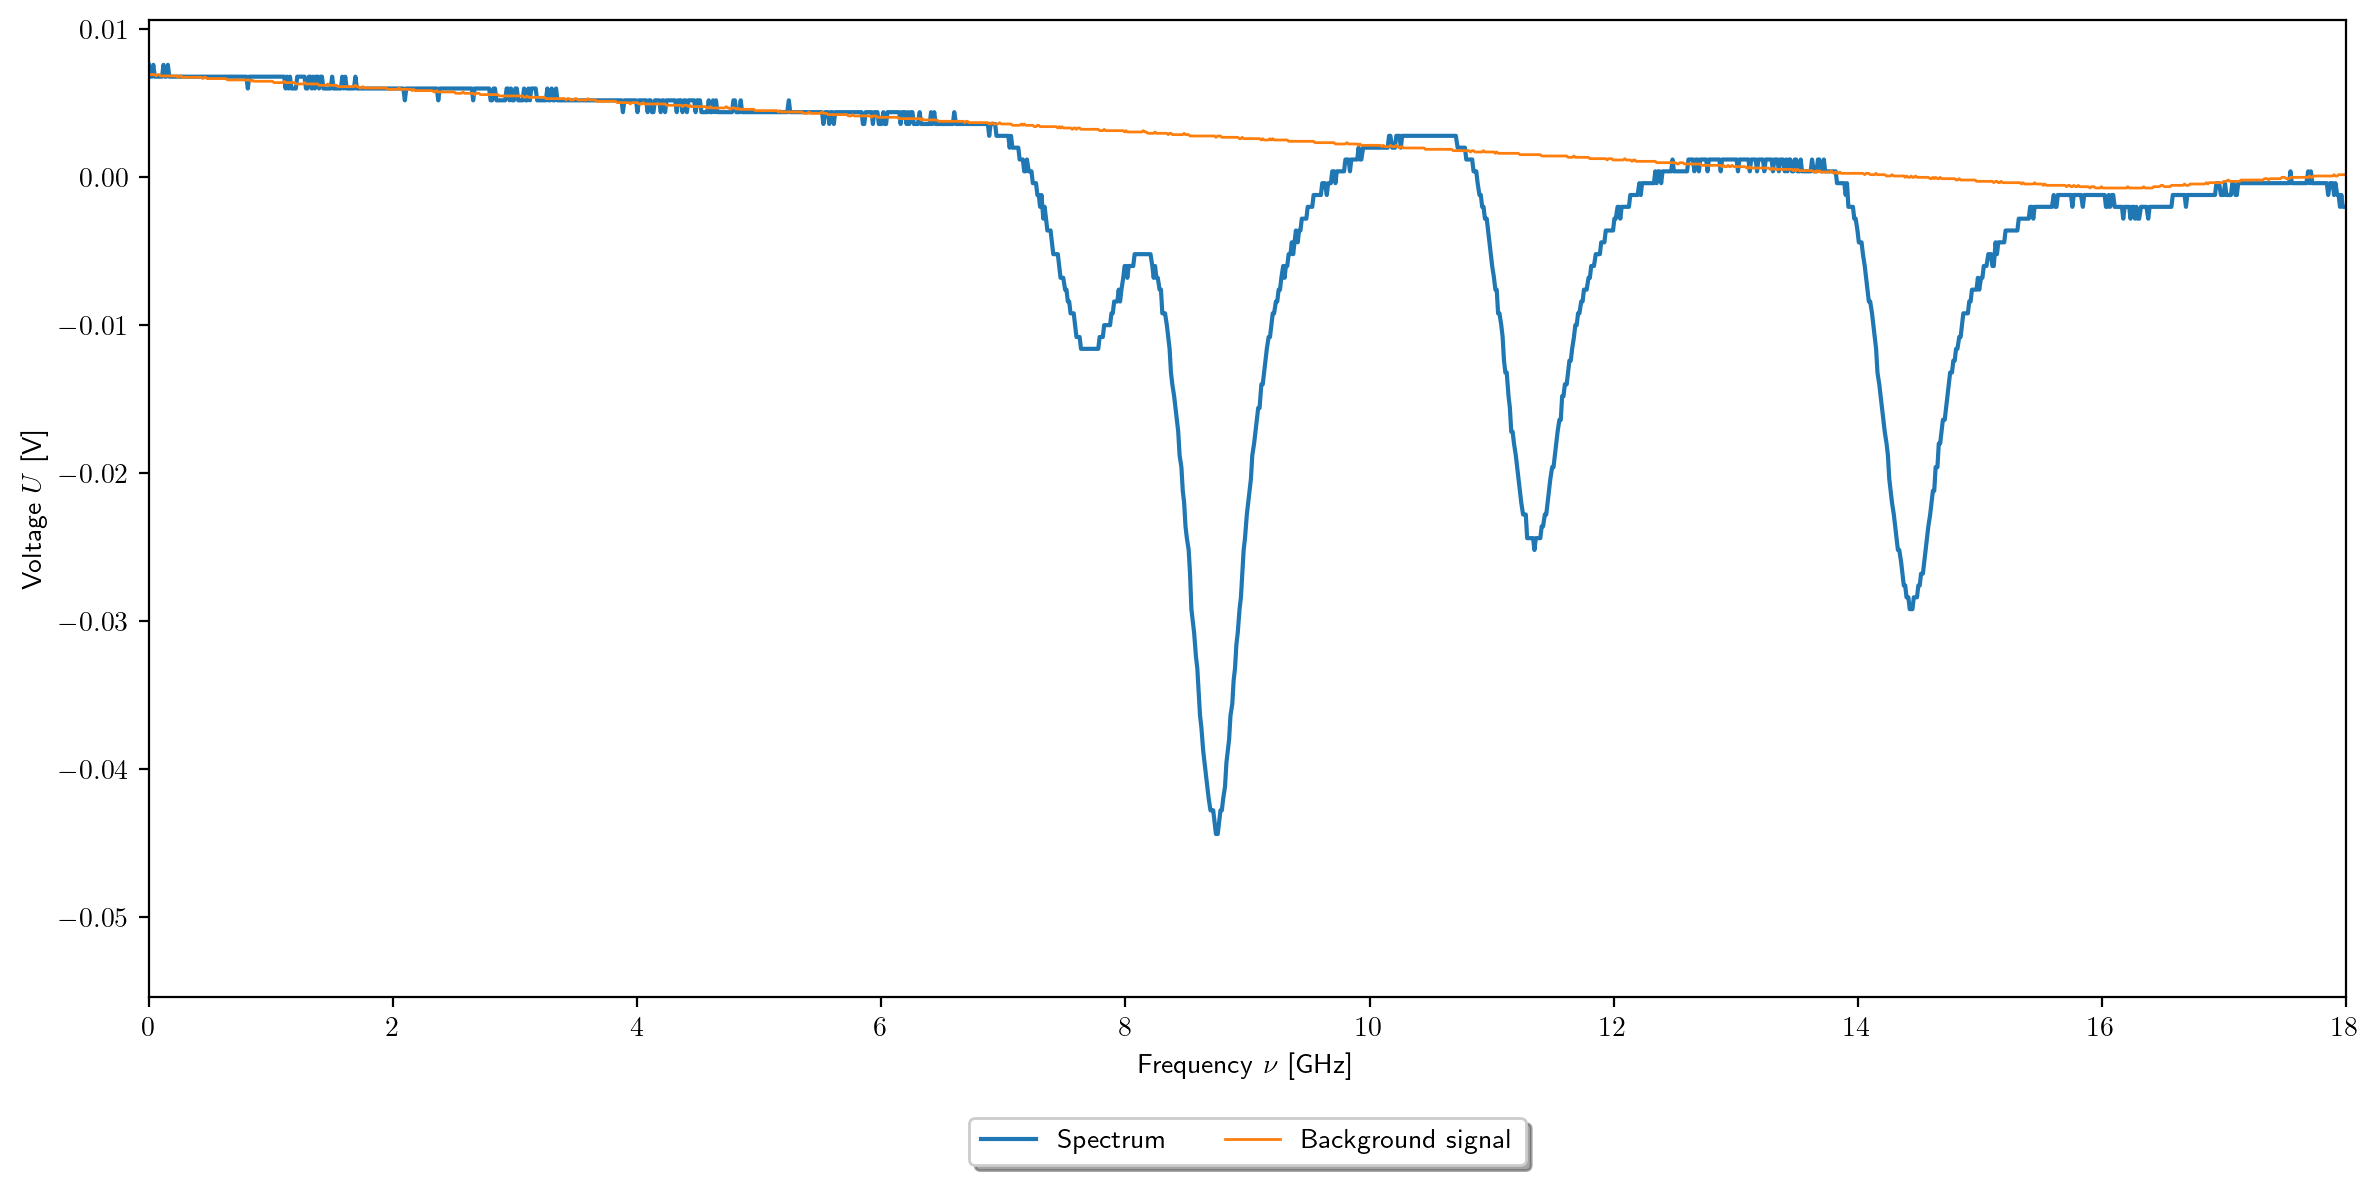

In [6]:
# scaliing
t0 = t[0]
print("t0 =", t0)

freq = alpha * (time - t0)
plt.figure(figsize=(12,6), dpi=200)
plt.plot(freq/1e9, ch2, label=r"Spectrum")
plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.grid(False)
plt.xlim(0,18)
plt.savefig("A1_signal_raw.pdf")
plt.show()

# changing to GHz 
freq_GHz = freq/1e9

# determination of background -> just fiiting the linear parts about the upper 30%
mask_bg = ch2 > np.percentile(ch2, 50)   

# Fit: CH2_bg = a*CH3 + b -> using signal from ch3 for background
coeffs = np.polyfit(ch3[mask_bg], ch2[mask_bg], deg=1)
a, b = coeffs

# printing the fit function 
print(f"Background-Fit: CH2_bg = {a:.4f} * CH3 + {b:.4f}")

# computing the background with the fit function
background = a * ch3 + b

# subtraction of ch2 and background -> real ch2 signal
ch2_corr = ch2 - background

# plotting the subtraction of ch2 and background
plt.figure(figsize=(12,6), dpi=200)
plt.plot(freq_GHz, ch2_corr, label=r"Corrected spectrum")
plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
plt.xlim(0,18)
#plt.title("Rubidium absorption (CH3-based background corrected)")
plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig("A1_signal.pdf")
plt.show()

# plotting the background signal to ensure correct working
plt.figure(figsize=(12,6), dpi=200)
plt.plot(freq_GHz, ch2, label=r"Spectrum")
plt.plot(freq_GHz, background, label=r"Background signal", linewidth=1)
plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
plt.xlim(0,18)
#plt.title("Background fit using CH3 ramp")
plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig("A1_signal_background.pdf")
plt.show()

## Beschriftetes Spektrum

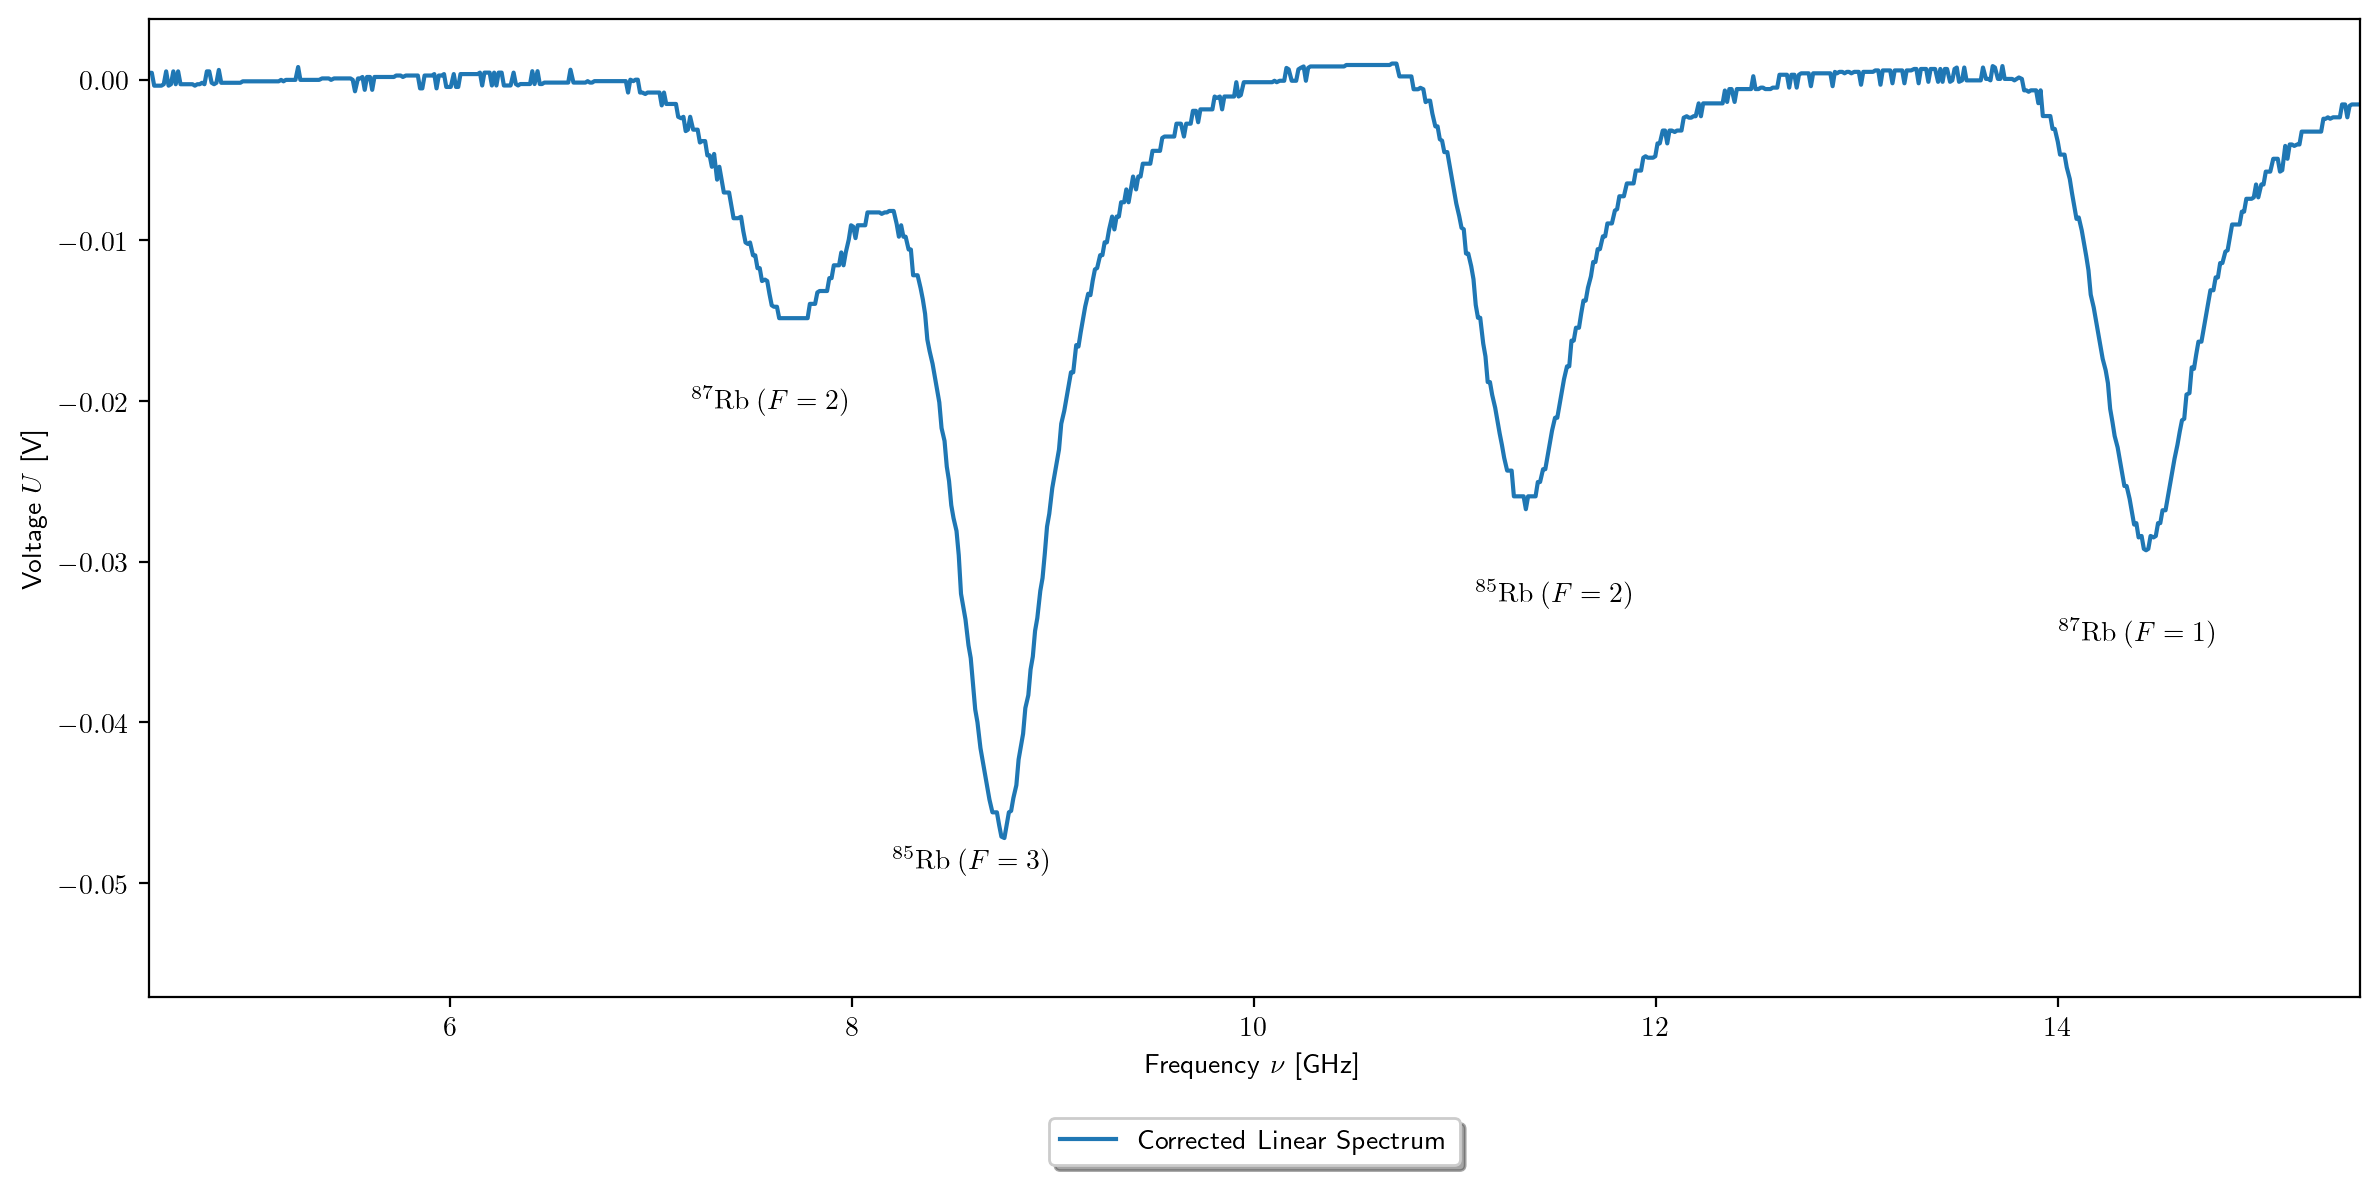

In [24]:
# plotting the subtraction of ch2 and background
plt.figure(figsize=(12,6), dpi=200)
plt.plot(freq_GHz, ch2_corr, label=r"Corrected Linear Spectrum")

# Positionen der Minima:
x1, x2, x3, x4 = 7.6, 8.6, 11.5, 14.4

# y-Werte interpolieren:
y1 = np.interp(x1, freq_GHz, ch2_corr)
y2 = np.interp(x2, freq_GHz, ch2_corr)
y3 = np.interp(x3, freq_GHz, ch2_corr)
y4 = np.interp(x4, freq_GHz, ch2_corr)

# Texte unterhalb der Minima platzieren (va='top'):
plt.text(x1, y1 - 0.005, r"$^{87}\mathrm{Rb}\:(F=2)$", ha="center", va="top")
plt.text(x2, y2 - 0.01, r"$^{85}\mathrm{Rb}\:(F=3)$", ha="center", va="top")
plt.text(x3, y3 - 0.01, r"$^{85}\mathrm{Rb}\:(F=2)$", ha="center", va="top")
plt.text(x4, y4 - 0.005, r"$^{87}\mathrm{Rb}\:(F=1)$", ha="center", va="top")


plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
#plt.title("Rubidium absorption (CH3-based background corrected)")
plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.xlim(4.5,15.5)

plt.savefig("A1_signal_beschriftet_Linear.pdf")
plt.show()

In [26]:
"""
Gaussian Fit Function----------------------------------------------------------------------------------------------
"""
def gauss(x, A, mu, sigma, C):
    return C + A * np.exp(-(x - mu)**2 / (2 * sigma**2))


# determining the intervals -> to compute 4 seperate Gauß Fit
intervals = [
    (6, 8.1),
    (8.1, 9.5),
    (10.5, 12),
    (12.5, 16)
]

peak_centers = []
fit_curves = []  
fit_params = []

# fitting
for fmin, fmax in intervals:

    mask = (freq_GHz >= fmin) & (freq_GHz <= fmax)
    x = np.array(freq_GHz[mask])
    y = np.array(ch2_corr[mask])

    # starting values
    peaks, _ = find_peaks(-y)
    if len(peaks) == 0:
        print("Kein Peak gefunden in", fmin, fmax)
        continue

    deepest = peaks[np.argmin(y[peaks])]
    mu0 = x[deepest]
    A0 = np.min(y) - np.max(y)
    sigma0 = 0.3
    C0 = np.max(y)

    # fitting
    p0 = [A0, mu0, sigma0, C0]
    popt, pcov = curve_fit(gauss, x, y, p0=p0)

    A, mu, sigma, C = popt
    FWHM = 2 * np.sqrt(2*np.log(2)) * sigma
    peak_centers.append(mu)
    fit_params.append((A, mu, sigma, C, FWHM))
    # stroing the fit curves
    xfit = np.linspace(fmin, fmax, 400)
    yfit = gauss(xfit, *popt)
    fit_curves.append((xfit, yfit))


# producing a plot
plt.figure(figsize=(12,6), dpi=200)
plt.plot(freq_GHz, ch2_corr, label=r"Spectrum", color="black", linewidth=0.8)

colors = ["red", "blue", "green", "orange"]

for i, ((xfit, yfit), col) in enumerate(zip(fit_curves, colors), start=1):

    # Plot Gaussian curve
    plt.plot(xfit, yfit, color=col, linewidth=0.8,
             label=fr"Fit {i}: $\mu_{i}={fit_params[i-1][1]:.3f}$ GHz,  FWHM$_{i}={fit_params[i-1][4]:.3f}$ GHz")

#for (xfit, yfit), col in zip(fit_curves, colors):
#    plt.plot(xfit, yfit, color=col, linewidth=2)

# Positionen der Minima:
x1, x2, x3, x4 = 7.6, 8.6, 11.5, 14.4

# y-Werte interpolieren:
y1 = np.interp(x1, freq_GHz, ch2_corr)
y2 = np.interp(x2, freq_GHz, ch2_corr)
y3 = np.interp(x3, freq_GHz, ch2_corr)
y4 = np.interp(x4, freq_GHz, ch2_corr)

# Texte unterhalb der Minima platzieren (va='top'):
plt.text(x1, y1 - 0.005, r"$^{87}\mathrm{Rb}\:(F=2)$", ha="center", va="top")
plt.text(x2, y2 - 0.01, r"$^{85}\mathrm{Rb}\:(F=3)$", ha="center", va="top")
plt.text(x3, y3 - 0.01, r"$^{85}\mathrm{Rb}\:(F=2)$", ha="center", va="top")
plt.text(x4, y4 - 0.005, r"$^{87}\mathrm{Rb}\:(F=1)$", ha="center", va="top")

plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
plt.xlim(0,18)
#plt.xlim(2,10.75)
#plt.title("Rb Spectrum with 4 Gaussian Fits")
plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig("A1_gausfit_spectrum.pdf")
plt.close()

print("\n--- Gaussian Fit Parameters ---\n")

for i, (A, mu, sigma, C, FWHM) in enumerate(fit_params, start=1):
    print(f"Fit {i}:")
    print(f"  A      = {A:.6f}")
    print(f"  mu     = {mu:.6f} GHz")
    print(f"  sigma  = {sigma:.6f} GHz")
    print(f"  FWHM   = {FWHM:.6f} GHz")
    print(f"  offset = {C:.6f}")
    print("")
    
# printing the peak centers 
peak_centers = np.sort(np.array(peak_centers))

print("\nGefittete Peak-Zentren µ (GHz):")
for i, mu in enumerate(peak_centers):
    print(f"{i+1}: {mu:.6f} GHz")

print("\nAbstände delta nu zwischen Peaks:")
distances = np.diff(peak_centers)
for i, d in enumerate(distances):
    print(f"deltanu_{i+1} = {d:.6f} GHz ({d*1000:.1f} MHz)")



--- Gaussian Fit Parameters ---

Fit 1:
  A      = -0.014712
  mu     = 7.731461 GHz
  sigma  = 0.296350 GHz
  FWHM   = 0.697851 GHz
  offset = -0.000029

Fit 2:
  A      = -0.038664
  mu     = 8.742853 GHz
  sigma  = 0.214680 GHz
  FWHM   = 0.505534 GHz
  offset = -0.006955

Fit 3:
  A      = -0.025850
  mu     = 11.381296 GHz
  sigma  = 0.258468 GHz
  FWHM   = 0.608644 GHz
  offset = 0.000566

Fit 4:
  A      = -0.026996
  mu     = 14.470018 GHz
  sigma  = 0.253862 GHz
  FWHM   = 0.597800 GHz
  offset = -0.000531


Gefittete Peak-Zentren µ (GHz):
1: 7.731461 GHz
2: 8.742853 GHz
3: 11.381296 GHz
4: 14.470018 GHz

Abstände delta nu zwischen Peaks:
deltanu_1 = 1.011392 GHz (1011.4 MHz)
deltanu_2 = 2.638443 GHz (2638.4 MHz)
deltanu_3 = 3.088722 GHz (3088.7 MHz)


In [27]:
"""
Gaussian Fit Function----------------------------------------------------------------------------------------------
"""
def gauss(x, A, mu, sigma, C):
    return C + A * np.exp(-(x - mu)**2 / (2 * sigma**2))


# determining the intervals -> to compute 4 separate Gauß fits
intervals = [
    (6, 8.1),
    (8.1, 9.5),
    (10.5, 12),
    (12.5, 16)
]

peak_centers = []
fit_curves = []  
fit_params = []
fit_errors = []   # NEW: store parameter errors

# fitting
for fmin, fmax in intervals:

    mask = (freq_GHz >= fmin) & (freq_GHz <= fmax)
    x = np.array(freq_GHz[mask])
    y = np.array(ch2_corr[mask])

    # starting values
    peaks, _ = find_peaks(-y)
    if len(peaks) == 0:
        print("Kein Peak gefunden in", fmin, fmax)
        continue

    deepest = peaks[np.argmin(y[peaks])]
    mu0 = x[deepest]
    A0 = np.min(y) - np.max(y)
    sigma0 = 0.3
    C0 = np.max(y)

    # fitting
    p0 = [A0, mu0, sigma0, C0]
    popt, pcov = curve_fit(gauss, x, y, p0=p0)

    A, mu, sigma, C = popt

    # --- NEW: parameter errors from covariance ---
    A_err, mu_err, sigma_err, C_err = np.sqrt(np.diag(pcov))

    # FWHM + error (propagation)
    FWHM = 2 * np.sqrt(2*np.log(2)) * sigma
    FWHM_err = 2 * np.sqrt(2*np.log(2)) * sigma_err

    peak_centers.append(mu)
    fit_params.append((A, mu, sigma, C, FWHM))
    fit_errors.append((A_err, mu_err, sigma_err, C_err, FWHM_err))

    # storing the fit curves
    xfit = np.linspace(fmin, fmax, 400)
    yfit = gauss(xfit, *popt)
    fit_curves.append((xfit, yfit))


# producing a plot
plt.figure(figsize=(12,6), dpi=200)
plt.plot(freq_GHz, ch2_corr, label=r"Spectrum", color="black", linewidth=0.8)

colors = ["red", "blue", "green", "orange"]

for i, ((xfit, yfit), col) in enumerate(zip(fit_curves, colors), start=1):

    mu    = fit_params[i-1][1]
    muerr = fit_errors[i-1][1]
    FWHM  = fit_params[i-1][4]
    FWHM_err = fit_errors[i-1][4]

    # Gaussian curve with parameter labels including errors
    plt.plot(
        xfit, yfit, color=col, linewidth=0.8,
        label=fr"Fit {i}: $\mu_{i}$={mu:.3f}$\pm${muerr:.3f} GHz,  "
              fr"FWHM$_{i}$={FWHM:.3f}$\pm${FWHM_err:.3f} GHz"
    )
# Positionen der Minima:
x1, x2, x3, x4 = 7.6, 8.6, 11.5, 14.4

# y-Werte interpolieren:
y1 = np.interp(x1, freq_GHz, ch2_corr)
y2 = np.interp(x2, freq_GHz, ch2_corr)
y3 = np.interp(x3, freq_GHz, ch2_corr)
y4 = np.interp(x4, freq_GHz, ch2_corr)

# Texte unterhalb der Minima platzieren (va='top'):
plt.text(x1, y1 - 0.005, r"$^{87}\mathrm{Rb}\:(F=2)$", ha="center", va="top")
plt.text(x2, y2 - 0.01, r"$^{85}\mathrm{Rb}\:(F=3)$", ha="center", va="top")
plt.text(x3, y3 - 0.01, r"$^{85}\mathrm{Rb}\:(F=2)$", ha="center", va="top")
plt.text(x4, y4 - 0.005, r"$^{87}\mathrm{Rb}\:(F=1)$", ha="center", va="top")


plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
plt.xlim(0,18)
plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11),
           fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig("A1_gausfit_spectrum.pdf")
plt.close()

print("\n--- Gaussian Fit Parameters (with errors) ---\n")

for i, ((A, mu, sigma, C, FWHM), (A_err, mu_err, sigma_err, C_err, FWHM_err)) in \
        enumerate(zip(fit_params, fit_errors), start=1):

    print(f"Fit {i}:")
    print(f"  A      = {A:.6f} ± {A_err:.6f}")
    print(f"  mu     = {mu:.6f} ± {mu_err:.6f} GHz")
    print(f"  sigma  = {sigma:.6f} ± {sigma_err:.6f} GHz")
    print(f"  FWHM   = {FWHM:.6f} ± {FWHM_err:.6f} GHz")
    print(f"  offset = {C:.6f} ± {C_err:.6f}")
    print("")

# printing the peak centers 
peak_centers = np.sort(np.array(peak_centers))

print("\nGefittete Peak-Zentren µ (GHz):")
for i, mu in enumerate(peak_centers):
    print(f"{i+1}: {mu:.6f} GHz")

print("\nAbstände delta nu zwischen Peaks:")
distances = np.diff(peak_centers)
for i, d in enumerate(distances):
    print(f"deltanu_{i+1} = {d:.6f} GHz ({d*1000:.1f} MHz)")



--- Gaussian Fit Parameters (with errors) ---

Fit 1:
  A      = -0.014712 ± 0.000081
  mu     = 7.731461 ± 0.001998 GHz
  sigma  = 0.296350 ± 0.002479 GHz
  FWHM   = 0.697851 ± 0.005838 GHz
  offset = -0.000029 ± 0.000043

Fit 2:
  A      = -0.038664 ± 0.000234
  mu     = 8.742853 ± 0.001239 GHz
  sigma  = 0.214680 ± 0.001854 GHz
  FWHM   = 0.505534 ± 0.004367 GHz
  offset = -0.006955 ± 0.000181

Fit 3:
  A      = -0.025850 ± 0.000404
  mu     = 11.381296 ± 0.003524 GHz
  sigma  = 0.258468 ± 0.005681 GHz
  FWHM   = 0.608644 ± 0.013378 GHz
  offset = 0.000566 ± 0.000346

Fit 4:
  A      = -0.026996 ± 0.000295
  mu     = 14.470018 ± 0.003101 GHz
  sigma  = 0.253862 ± 0.003410 GHz
  FWHM   = 0.597800 ± 0.008030 GHz
  offset = -0.000531 ± 0.000107


Gefittete Peak-Zentren µ (GHz):
1: 7.731461 GHz
2: 8.742853 GHz
3: 11.381296 GHz
4: 14.470018 GHz

Abstände delta nu zwischen Peaks:
deltanu_1 = 1.011392 GHz (1011.4 MHz)
deltanu_2 = 2.638443 GHz (2638.4 MHz)
deltanu_3 = 3.088722 GHz (3088.7 

### Computing the hyperfine constant A

In [116]:
dnu_87 = 6.739   # GHz
dnu_87_err = 0.004  # GHz

dnu_85 = 2.638
dnu_85_err = 0.004

# ------------------------------------------------------
# K-Werte berechnen
# ------------------------------------------------------

def K(F, I, J):
    return F*(F+1) - I*(I+1) - J*(J+1)

# 87Rb: I = 3/2, J = 1/2, F = 1, 2
I_87, J_87 = 1.5, 0.5
K1_87 = K(1, I_87, J_87)
K2_87 = K(2, I_87, J_87)
dK_87 = K2_87 - K1_87   # sollte = 4 sein

# 85Rb: I = 5/2, J = 1/2, F = 2, 3
I_85, J_85 = 2.5, 0.5
K2_85 = K(2, I_85, J_85)
K3_85 = K(3, I_85, J_85)
dK_85 = K3_85 - K2_85   # sollte = 6 sein

# ------------------------------------------------------
# Berechnung A/h aus A/h = 2 Δν / ΔK
# ------------------------------------------------------

A87_over_h = 2 * dnu_87 / dK_87
A85_over_h = 2 * dnu_85 / dK_85

# ------------------------------------------------------
# Gaußsche Fehlerfortpflanzung:
# A/h = (2 / ΔK) * Δν
# daher: σ(A/h) = (2 / ΔK) * σ(Δν)
# ------------------------------------------------------

A87_err = (2 / dK_87) * dnu_87_err
A85_err = (2 / dK_85) * dnu_85_err

# ------------------------------------------------------
# Ausgabe
# ------------------------------------------------------
print("=== Hyperfine Constant A/h ===")
print(f"A_87 / h = {A87_over_h:.4f} ± {A87_err:.4f} GHz")
print(f"A_85 / h = {A85_over_h:.4f} ± {A85_err:.4f} GHz")

print("\n=== K-Werte (Kontrolle) ===")
print(f"dK (87Rb) = {dK_87}")
print(f"dK (85Rb) = {dK_85}")


=== Hyperfine Constant A/h ===
A_87 / h = 3.3695 ± 0.0020 GHz
A_85 / h = 0.8793 ± 0.0013 GHz

=== K-Werte (Kontrolle) ===
dK (87Rb) = 4.0
dK (85Rb) = 6.0
